In [3]:
# load modules
import pandas as pd
import numpy as np
import pandas as pd
from collections import defaultdict, Counter, OrderedDict
import pickle
from sklearn.neighbors import kneighbors_graph
import phenograph
from scipy.stats import zscore, ttest_ind
import scanpy as sc
# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import statsmodels.api as sm
import statsmodels.stats.weightstats as stats
from scipy import stats
from scipy.stats import wasserstein_distance


import random
##function to generate random colors for coloring clusters
def random_colors(n): #n is the number of colors you need to generate
    color_set = np.zeros((n,3))
    for i in range(n):
        r = random.uniform(0, 1)
        b = random.uniform(0, 1)
        g = random.uniform(0, 1)
        color_set[i] = [r,b,g]
    return color_set

cmap = plt.cm.Spectral_r

import numba
import umap.umap_ as umap
import umap
import anndata



In [4]:
umap_ = pd.read_csv('mainmap_umap_0811.csv', index_col = 0)
umap_ = umap_[umap_['BM']=='BM']

# MAIN BOXPLOTS - using all BM cells

In [5]:
## BOXPLOTS FOR MAIN CLUSTERS
### Create dataframes that split all data into response groups

# umap_ = umap_.loc[myeloid_cells]

cml = umap_[umap_['DATA']=='CML']
cml_r = cml[cml['response']=='RESPONDER']
cml_nr = cml[cml['response']=='NONRESPONDER']
cml_r_pre = cml_r[cml_r['time']=='PRE']
cml_r_post = cml_r[cml_r['time']=='POST']
cml_nr_pre = cml_nr[cml_nr['time']=='PRE']
cml_nr_post = cml_nr[cml_nr['time']=='POST']

print('CML: ')
total_r_pre = cml_r_pre.shape[0]
total_nr_pre = cml_nr_pre.shape[0]
print('R_pre: ',total_r_pre,'NR_pre: ',total_nr_pre)

total_r_post = cml_r_post.shape[0]
total_nr_post = cml_nr_post.shape[0]
print('R_post: ',total_r_post,'NR_post: ',total_nr_post)

aml = umap_[umap_['DATA']=='AML']
aml_r = aml[aml['response']=='RESPONDER']
aml_nr = aml[aml['response']=='NONRESPONDER']
aml_r_pre = aml_r[aml_r['time']=='PRE']
aml_r_post = aml_r[aml_r['time']=='POST']
aml_nr_pre = aml_nr[aml_nr['time']=='PRE']
aml_nr_post = aml_nr[aml_nr['time']=='POST']

print('AML: ')
total_r_pre = aml_r_pre.shape[0]
total_nr_pre = aml_nr_pre.shape[0]
print('R_pre: ',total_r_pre,'NR_pre: ',total_nr_pre)

total_r_post = aml_r_post.shape[0]
total_nr_post = aml_nr_post.shape[0]
print('R_post: ',total_r_post,'NR_post: ',total_nr_post)

### Count number of cells in each cluster that belong to each sample

cellcount_df = pd.DataFrame(index = np.unique(umap_['sample']), columns = np.unique(umap_['cluster_number'].astype(str)))
cellcount_df['total'] = np.zeros(len(cellcount_df))

for sample in np.unique(umap_['sample']):

    df = umap_[umap_['sample']==sample]
    cellcount_df.loc[sample,'total'] = len(df)
    
    for cluster in np.unique(umap_['cluster_number'].astype(str)):
        cluster_len = len(df[df['cluster_number']==int(cluster)])
        cellcount_df.loc[sample,cluster] = cluster_len 
    
ms = cellcount_df.sum(axis=0)
cellcount_df = cellcount_df.drop(columns = cellcount_df.loc[:,ms==0].columns)

#drop clusters that don't have cells in any AML BM samples
cellcount_df = cellcount_df[cellcount_df['total']>0]

# divide by total number of cells in that sample
cellratio_df = cellcount_df.div(cellcount_df['total'],axis = 0)

P_VALUE = 0.05
## R vs. NR

#get list of all samples for each response group
aml_r_pre_samples = np.unique(aml_r_pre['sample'])
aml_r_post_samples = np.unique(aml_r_post['sample'])
aml_nr_pre_samples = np.unique(aml_nr_pre['sample'])
aml_nr_post_samples = np.unique(aml_nr_post['sample'])


cml_r_pre_samples = np.unique(cml_r_pre['sample'])
cml_r_post_samples = np.unique(cml_r_post['sample'])
cml_nr_pre_samples = np.unique(cml_nr_pre['sample'])
cml_nr_post_samples = np.unique(cml_nr_post['sample'])


# calculate all ratios for each response group
aml_r_pre_ratios = cellratio_df.loc[aml_r_pre_samples,:]
aml_r_post_ratios = cellratio_df.loc[aml_r_post_samples,:]

# if needed to artifially include 0's when using the myeloid only cells
# aml_r_post_ratios.loc['LB_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['KC_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['EL_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['MS_post'] = np.zeros(len(aml_r_post_ratios.columns))


aml_nr_pre_ratios = cellratio_df.loc[aml_nr_pre_samples,:]
aml_nr_post_ratios = cellratio_df.loc[aml_nr_post_samples,:]

cml_r_pre_ratios = cellratio_df.loc[cml_r_pre_samples,:]
cml_r_post_ratios = cellratio_df.loc[cml_r_post_samples,:]
cml_nr_pre_ratios = cellratio_df.loc[cml_nr_pre_samples,:]
cml_nr_post_ratios = cellratio_df.loc[cml_nr_post_samples,:]


##### COMPARING R AND NR

sample_R = aml_r_pre_ratios
sample_NR = aml_nr_pre_ratios
p_value_pre_aml = []
print('AML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue   
    if i=='total': continue
        
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]
    p_value_pre_aml.append(p)
        
        
sample_R = cml_r_pre_ratios
sample_NR = cml_nr_pre_ratios
p_value_pre = []
print('CML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_pre.append(p)


sample_R = aml_r_post_ratios
sample_NR = aml_nr_post_ratios
p_value_post_aml = []
print('AML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
        
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   

    p_value_post_aml.append(p)
        
        
sample_R = cml_r_post_ratios
sample_NR = cml_nr_post_ratios
p_value_post = []
print('CML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_post.append(p)
    
    
    
### COMPARING PRE AND POST

sample_R = aml_r_pre_ratios
sample_NR = aml_r_post_ratios
p_value_r_aml = []
print('AML R')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue  
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_r_aml.append(p)

        
        
sample_R = cml_r_pre_ratios
sample_NR = cml_r_post_ratios
p_value_r = []
print('CML R')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_r.append(p)

    
    

sample_R = aml_nr_pre_ratios
sample_NR = aml_nr_post_ratios
p_value_nr_aml = []
print('AML NR')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue  
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_nr_aml.append(p)

        
        
sample_R = cml_nr_pre_ratios
sample_NR = cml_nr_post_ratios
p_value_nr = []
col_arr = []
print('CML NR')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    col_arr.append(i)
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_nr.append(p)



p_df = pd.DataFrame()

p_df['CML_R'] = p_value_r
p_df['CML_NR'] = p_value_nr
p_df['CML_PRE'] = p_value_pre
p_df['CML_POST'] = p_value_post


p_df['AML_R'] = p_value_r_aml
p_df['AML_NR'] = p_value_nr_aml
p_df['AML_PRE'] = p_value_pre_aml
p_df['AML_POST'] = p_value_post_aml

p_df.index= col_arr


# combined everything 

cml_r_pre_ratios['time']= np.repeat('PRE',len(cml_r_pre_ratios))
cml_r_post_ratios['time']= np.repeat('POST',len(cml_r_post_ratios))
aml_r_pre_ratios['time']= np.repeat('PRE',len(aml_r_pre_ratios))
aml_r_post_ratios['time']= np.repeat('POST',len(aml_r_post_ratios))

cml_nr_pre_ratios['time']= np.repeat('PRE',len(cml_nr_pre_ratios))
cml_nr_post_ratios['time']= np.repeat('POST',len(cml_nr_post_ratios))
aml_nr_pre_ratios['time']= np.repeat('PRE',len(aml_nr_pre_ratios))
aml_nr_post_ratios['time']= np.repeat('POST',len(aml_nr_post_ratios))

cml_r_pre_ratios['response']= np.repeat('R',len(cml_r_pre_ratios))
cml_nr_pre_ratios['response']= np.repeat('NR',len(cml_nr_pre_ratios))
aml_r_pre_ratios['response']= np.repeat('R',len(aml_r_pre_ratios))
aml_nr_pre_ratios['response']= np.repeat('NR',len(aml_nr_pre_ratios))

cml_r_post_ratios['response']= np.repeat('R',len(cml_r_post_ratios))
cml_nr_post_ratios['response']= np.repeat('NR',len(cml_nr_post_ratios))
aml_r_post_ratios['response']= np.repeat('R',len(aml_r_post_ratios))
aml_nr_post_ratios['response']= np.repeat('NR',len(aml_nr_post_ratios))

sample_ratios_aml_PRE = pd.concat([aml_r_pre_ratios,aml_nr_pre_ratios])
sample_ratios_cml_PRE = pd.concat([cml_r_pre_ratios,cml_nr_pre_ratios])
sample_ratios_aml_PRE = sample_ratios_aml_PRE.drop(columns = 'total')
sample_ratios_cml_PRE = sample_ratios_cml_PRE.drop(columns = 'total')

sample_ratios_aml_R = pd.concat([aml_r_pre_ratios,aml_r_post_ratios])
sample_ratios_cml_R = pd.concat([cml_r_pre_ratios,cml_r_post_ratios])
sample_ratios_aml_R = sample_ratios_aml_R.drop(columns = 'total')
sample_ratios_cml_R = sample_ratios_cml_R.drop(columns = 'total')

sample_ratios_aml_NR = pd.concat([aml_nr_pre_ratios,aml_nr_post_ratios])
sample_ratios_cml_NR = pd.concat([cml_nr_pre_ratios,cml_nr_post_ratios])
sample_ratios_aml_NR = sample_ratios_aml_NR.drop(columns = 'total')
sample_ratios_cml_NR = sample_ratios_cml_NR.drop(columns = 'total')

sample_cml = pd.concat([sample_ratios_cml_R,sample_ratios_cml_NR])
sample_aml = pd.concat([sample_ratios_aml_R,sample_ratios_aml_NR])
sample_cml['data'] = np.repeat('CML',len(sample_cml))
sample_aml['data'] = np.repeat('AML',len(sample_aml))

all_sample_ratios = pd.concat([sample_cml,sample_aml])

arr = []
for sample in all_sample_ratios.index:
    data = all_sample_ratios.loc[sample,'data']
    response = all_sample_ratios.loc[sample,'response']
    string = data+ '_'+response
    arr.append(string)

    
all_sample_ratios['data_response'] = arr

arr = []
arr1 = []
for sample in all_sample_ratios.index:
    data = all_sample_ratios.loc[sample,'data']
    time = all_sample_ratios.loc[sample,'time']
    response = all_sample_ratios.loc[sample,'response']
    string = data+ '_'+time
    arr.append(string)
    
    string1 = data+'_'+response+'_'+time
    arr1.append(string1)

    
all_sample_ratios['data_time'] = arr
all_sample_ratios['response_group'] = arr1
## add patient column:
patient_arr = []
for sample in all_sample_ratios.index:
#     print(sample)
    if sample == 'LB_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'MS_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'KC_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'EL_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    df_ = umap_[umap_['sample'] == sample]
    patient = np.unique(df_['patient'])[0]
    patient_arr.append(patient)
all_sample_ratios['patient'] = patient_arr



new_time_arr = []
for index in all_sample_ratios.index: 
    time = all_sample_ratios.loc[index, 'time']
    if time == 'PRE':
        new_time_arr.append('APRE')
    else: new_time_arr.append('POST')
all_sample_ratios['time'] = new_time_arr


aml_r_pre_color = '#70C8CE'
aml_r_post_color = '#0B7684'

aml_nr_pre_color = '#EEC0DA'
aml_nr_post_color = '#EA4E9D'

cml_r_pre_color = '#BFAFEF'
cml_r_post_color = '#664EA0'

cml_nr_pre_color = '#E8A577'
cml_nr_post_color = '#D57528'

sample_connect = ['B5_','B6_','B1_','B2_','B9_','B10_','B21_','B22_','B25_','B3_', 'B4_'
                  'B32_','B32_','B24_','B27_','B28_','B7_','B8_','B17_','B18_','B19_','B20_',
                  'E1_','E2_','E3_','E4_',
                 'MS4_', 'MS3_', 'LB3_','LB1_', 'EL1_', 'EL2_' , 'KC2_', 'KC4_', 'BB11_', 'BB2_', 
                 'GD1_', 'GD2_', 'AH1_', 'AH3_', 'JS1_', 'JS2_','LB_post','MS_post','KC_post' ,'EL_post',
                 'AML1_1','AML2']



p_df = p_df.dropna(axis = 1, how = 'all')



CML: 
R_pre:  88164 NR_pre:  81850
R_post:  85215 NR_post:  53469
AML: 
R_pre:  12861 NR_pre:  7724
R_post:  25168 NR_post:  1619
AML
CML
AML
CML
AML R
CML R
AML NR
CML NR


       patient  time          0
MS4_        MS  APRE    0.04047
MS3_        MS  POST   0.157765
LB3_        LB  APRE          0
LB1_        LB  POST   0.409022
EL1_        EL  APRE  0.0234114
EL2_        EL  POST  0.0178812
KC2_        KC  APRE  0.0149786
KC4_        KC  POST   0.437269
AML1_1      BB  APRE  0.0211512
AML2        BB  POST  0.0772443
     patient  time           0
GD1_      GD  APRE   0.0140232
GD2_      GD  POST   0.0215716
AH1_      AH  APRE    0.205128
AH3_      AH  POST      0.4375
JS1_      JS  APRE   0.0183908
JS2_      JS  POST  0.00726392


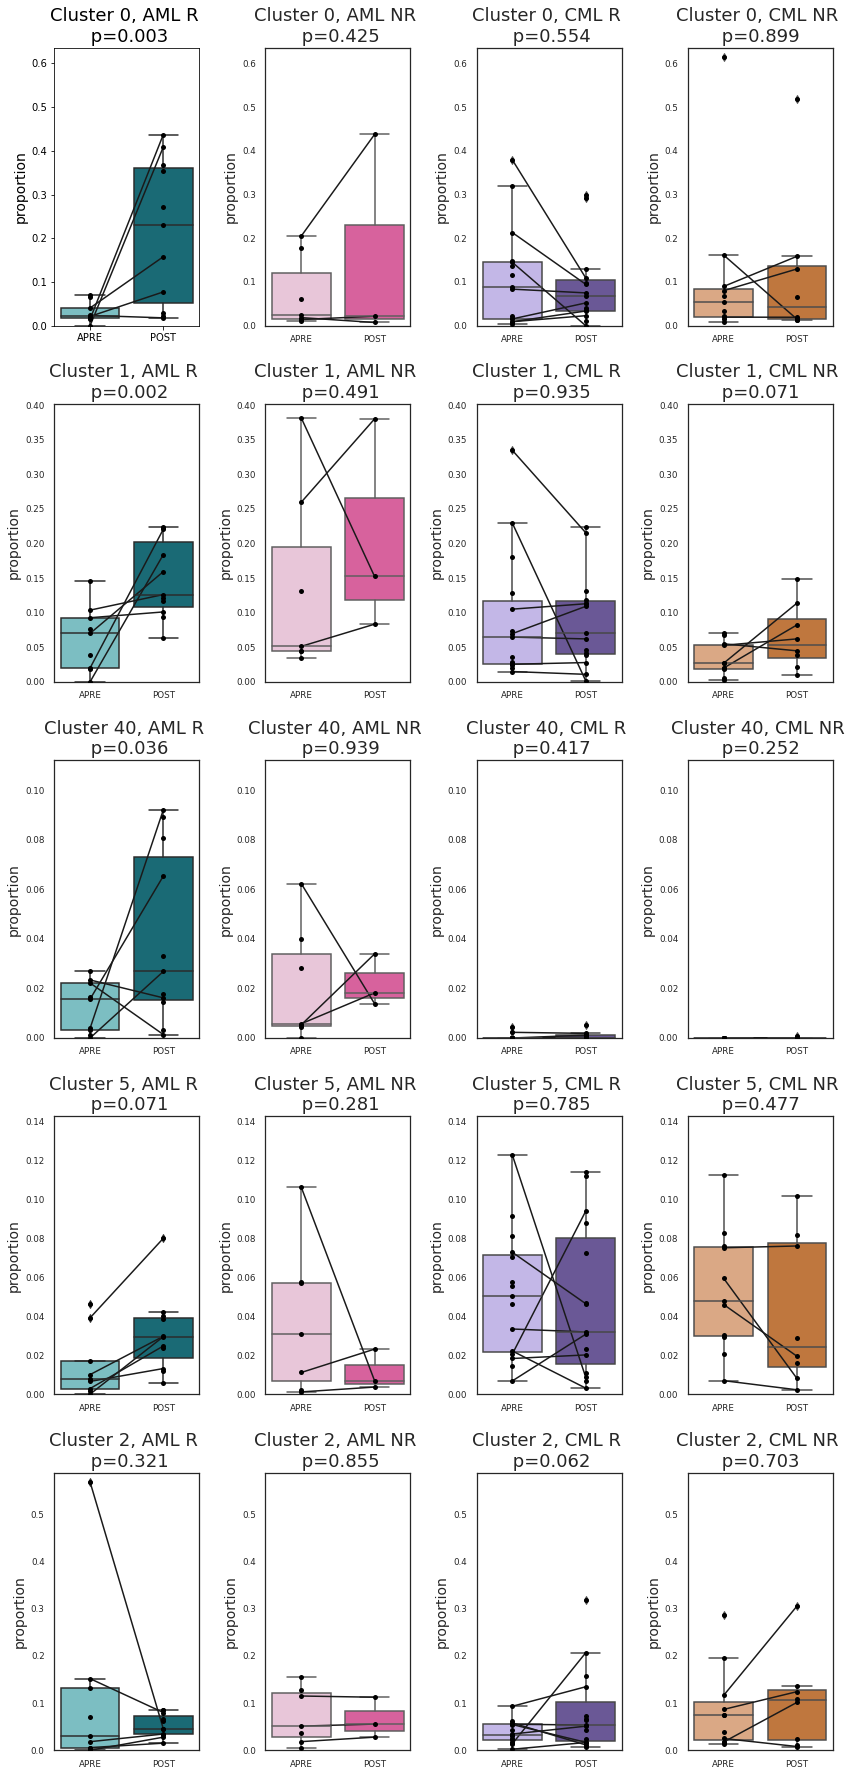

In [6]:



############## EXPANSIONS ############################

### BOX PLOTS OF ALL EXPANSIONS

p_df_expansion = p_df[['CML_R','CML_NR','AML_R','AML_NR']]
# p_df_expansion = p_df[['AML_R','AML_NR']]
cluster_arr = []
for cluster in p_df_expansion.index: 
    p = np.min(p_df_expansion.loc[cluster])
    if p>0.08: continue
    else: cluster_arr.append(cluster)

cluster_arr = ['0','1','40','5','2']
# cluster_arr = ['0']
        
n = len(cluster_arr)*4; max_cols = 4
nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
fig = plt.figure(figsize = [3*ncols, 5*nrows])
j = 0

for cluster in cluster_arr:
    
    aml = all_sample_ratios[all_sample_ratios['data']=='AML']
    aml_r = aml[aml['response']=='R']
    aml_nr = aml[aml['response']=='NR']

    cml = all_sample_ratios[all_sample_ratios['data']=='CML']
    cml_r = cml[cml['response']=='R']
    cml_nr = cml[cml['response']=='NR']
    # one figure for each expansion group (i.e. AML R pre->post is one group)

    


    aml_r_max = np.max(aml_r[cluster])
    aml_nr_max = np.max(aml_nr[cluster])
    cml_r_max = np.max(cml_r[cluster])
    cml_nr_max = np.max(cml_nr[cluster])
    a = [aml_r_max,aml_nr_max,cml_r_max,cml_nr_max]
    cleanedList = [x for x in a if str(x) != 'nan']
    max_y = np.max(cleanedList) + 0.02

    p_vals = p_df.loc[cluster]


    DF = aml_r
    color_set = [aml_r_pre_color, aml_r_post_color]
    p = np.round(p_vals['AML_R'],3)
    axes = fig.add_subplot(nrows, ncols, j+1)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    if cluster == '0': print(line_df)
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
#     print(f'CLUSTER {cluster}')
#     print(line_df)
    axes.set_title(f'Cluster {cluster}, AML R \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')

    DF = aml_nr
    color_set = [aml_nr_pre_color, aml_nr_post_color]
    p = np.round(p_vals['AML_NR'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+2)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    if cluster == '0': print(line_df)
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)

    axes.set_title(f'Cluster {cluster}, AML NR \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_r
    color_set = [cml_r_pre_color, cml_r_post_color]
    p = np.round(p_vals['CML_R'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+3)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
    #     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    axes.set_title(f'Cluster {cluster}, CML R \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_nr
    color_set = [cml_nr_pre_color, cml_nr_post_color]
    p = np.round(p_vals['CML_NR'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+4)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
    #     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    axes.set_title(f'Cluster {cluster}, CML NR \n p={p} ', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
    
    j += 4

fig.tight_layout(pad = 2) 
plt.show()






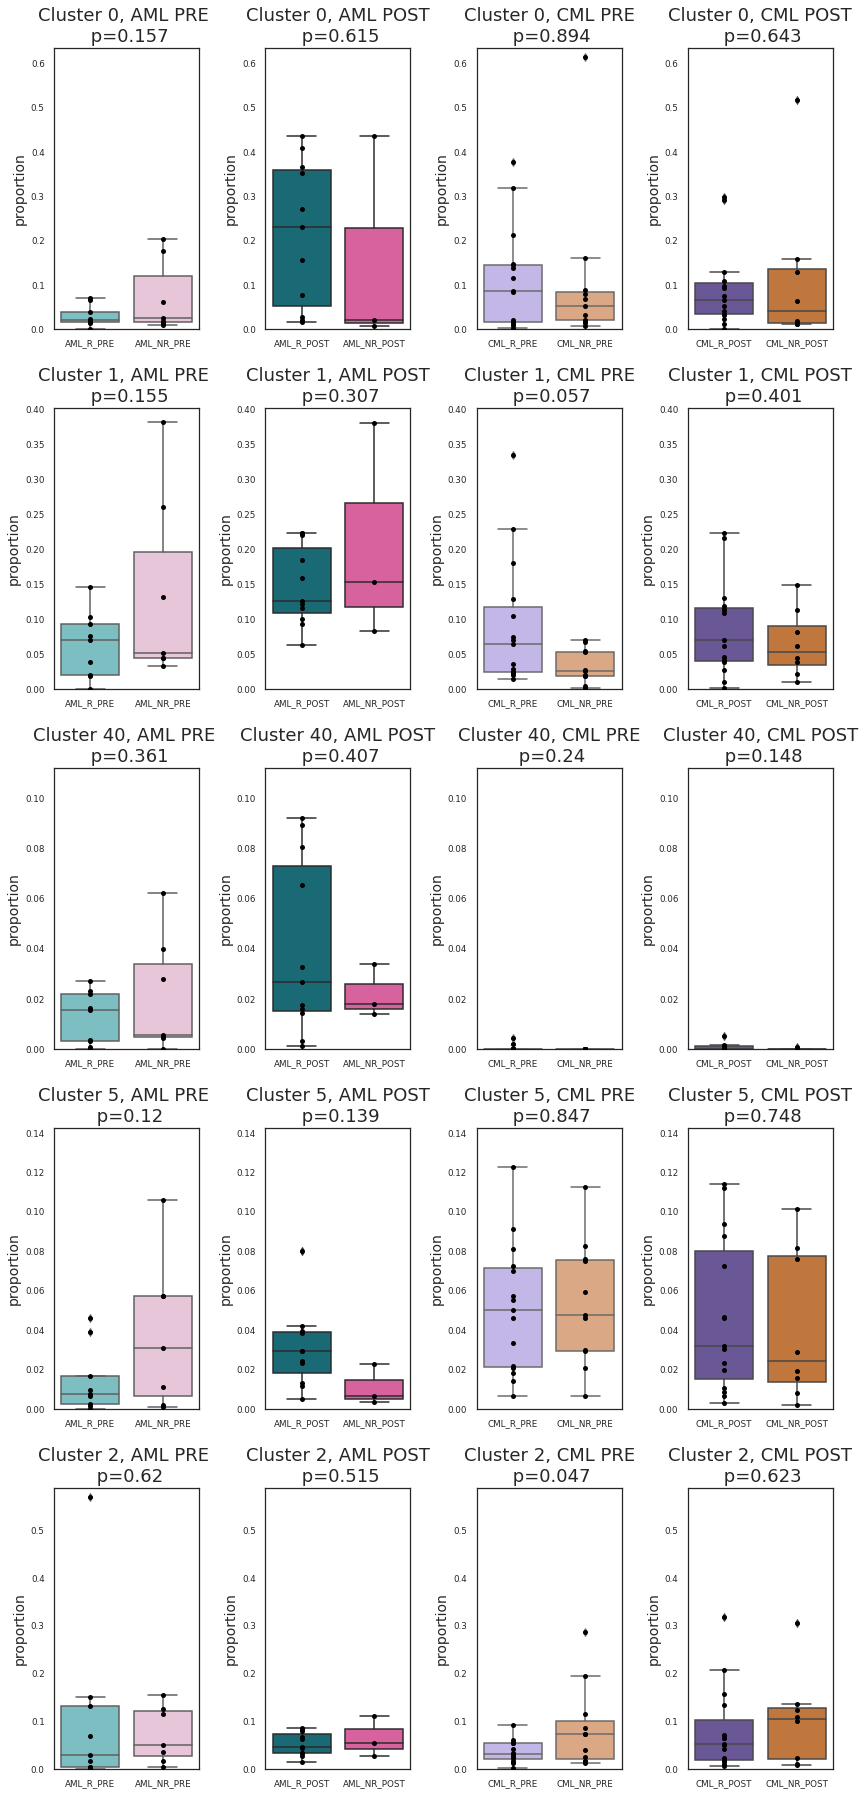

In [8]:
############## ENRICHMENTS ###################


# ### BOX PLOTS OF ALL EXPANSIONS
p_df_expansion = p_df[['CML_PRE','CML_POST','AML_PRE','AML_POST']]
# p_df_expansion = p_df[['AML_R','AML_NR']]
cluster_arr = []
for cluster in p_df_expansion.index: 
    p = np.min(p_df_expansion.loc[cluster])
    if p>0.08: continue
    else: cluster_arr.append(cluster)
        
# cluster_arr = tcells

# cluster_arr = np.unique(umap_['cluster_number'])



n = len(cluster_arr)*4; max_cols = 4
nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
fig = plt.figure(figsize = [3*ncols, 5*nrows])
j = 0
cluster_arr =  ['0','1','40','5','2']

for cluster in cluster_arr:
#     print(cluster)
#     if len(cluster_arr)==0: break
    
    aml = all_sample_ratios[all_sample_ratios['data']=='AML']
    aml_pre = aml[aml['time']=='APRE']
    aml_post = aml[aml['time']=='POST']

    cml = all_sample_ratios[all_sample_ratios['data']=='CML']
    cml_pre = cml[cml['time']=='APRE']
    cml_post = cml[cml['time']=='POST']
    
    # one figure for each expansion group (i.e. AML R pre->post is one group)
    aml_r_max = np.max(aml_pre[cluster])
    aml_nr_max = np.max(aml_post[cluster])
    cml_r_max = np.max(cml_pre[cluster])
    cml_nr_max = np.max(cml_post[cluster])

    a = [aml_r_max,aml_nr_max,cml_r_max,cml_nr_max]
    cleanedList = [x for x in a if str(x) != 'nan']
    max_y = np.max(cleanedList) + 0.02

    p_vals = p_df.loc[cluster]
    

    DF = aml_pre
    color_set = [aml_r_pre_color, aml_nr_pre_color]
    p = np.round(p_vals['AML_PRE'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+1)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, AML PRE \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
                   

    DF = aml_post
    color_set = [aml_r_post_color, aml_nr_post_color]
    p = np.round(p_vals['AML_POST'],3)
                   
                   
    axes = fig.add_subplot(nrows, ncols, j+2)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, AML POST\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_pre
    color_set = [cml_r_pre_color, cml_nr_pre_color]
    p = np.round(p_vals['CML_PRE'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+3)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, CML PRE\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_post
    color_set = [cml_r_post_color, cml_nr_post_color]
    p = np.round(p_vals['CML_POST'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+4)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, CML POST\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
    
    j += 4

fig.tight_layout(pad = 2) 
plt.show()



# BOXPLOTS USING ONLY LYMPHOCYTES

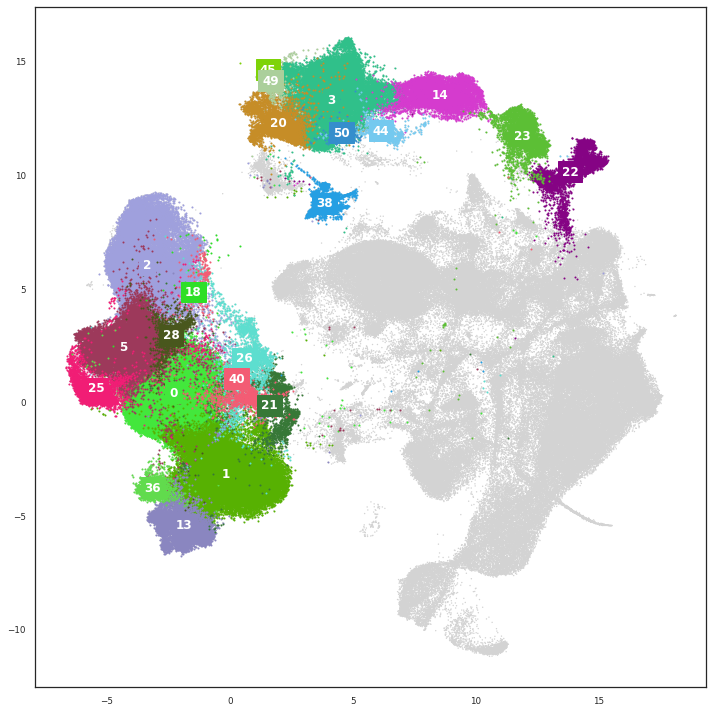

In [9]:
## REMOVE ALL MYELOID CELLS
umap_ = pd.read_csv('~/mainmap_umap_0811.csv', index_col = 0)
umap_ = umap_[umap_['BM']=='BM']
# umap_ = umap_[umap_['DATA']=='AML']

non_myeloid = [13,36,1,21,40,26,28,0,25,5,2,18,45,49,20,38,3,50,44,14,23,22]
myeloid_cells = pd.Index([])
plt.figure(figsize=(10,10))
plt.scatter(umap_['x'],umap_['y'],s=2, edgecolors='none',color = "lightgrey")

n_cluster_knn = np.amax(umap_['cluster_number'])
color_set_clusters = random_colors(n_cluster_knn + 2)
#loop through labels and plot each cluster
for cluster in range(n_cluster_knn + 1):
    if cluster not in non_myeloid: continue
    #add data points 
    cells = umap_.index[umap_.cluster_number == cluster]
    myeloid_cells = myeloid_cells.union(cells)
    plt.scatter(x=umap_.loc[cells, 'x'], 
                y=umap_.loc[cells, 'y'], s=1,
                color=color_set_clusters[cluster], 
                alpha=1)
    
    #add label
    plt.annotate(cluster, 
                 umap_.loc[cells,['x','y']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=12, weight = 'bold',
                 color='white',
                 backgroundcolor=color_set_clusters[cluster]) 
    
plt.tight_layout()
# plt.savefig('umap_updated_clusters.eps')



umap_ = umap_.loc[myeloid_cells]

CML: 
R_pre:  44056 NR_pre:  36167
R_post:  51755 NR_post:  29162
AML: 
R_pre:  4259 NR_pre:  4237
R_post:  18669 NR_post:  796
AML
CML
AML
CML
AML R
CML R
AML NR
CML NR
       patient  time          0
MS4_        MS  APRE   0.161458
MS3_        MS  POST       0.24
LB3_        LB  APRE          0
LB1_        LB  POST   0.476181
EL1_        EL  APRE  0.0277778
EL2_        EL  POST  0.0513566
KC2_        KC  APRE  0.0634441
KC4_        KC  POST   0.455069
AML1_1      BB  APRE   0.049513
AML2        BB  POST   0.128324
     patient  time          0
GD1_      GD  APRE  0.0222905
GD2_      GD  POST  0.0555556
AH1_      AH  APRE   0.331361
AH3_      AH  POST   0.477273
JS1_      JS  APRE  0.0426667
JS2_      JS  POST  0.0145631


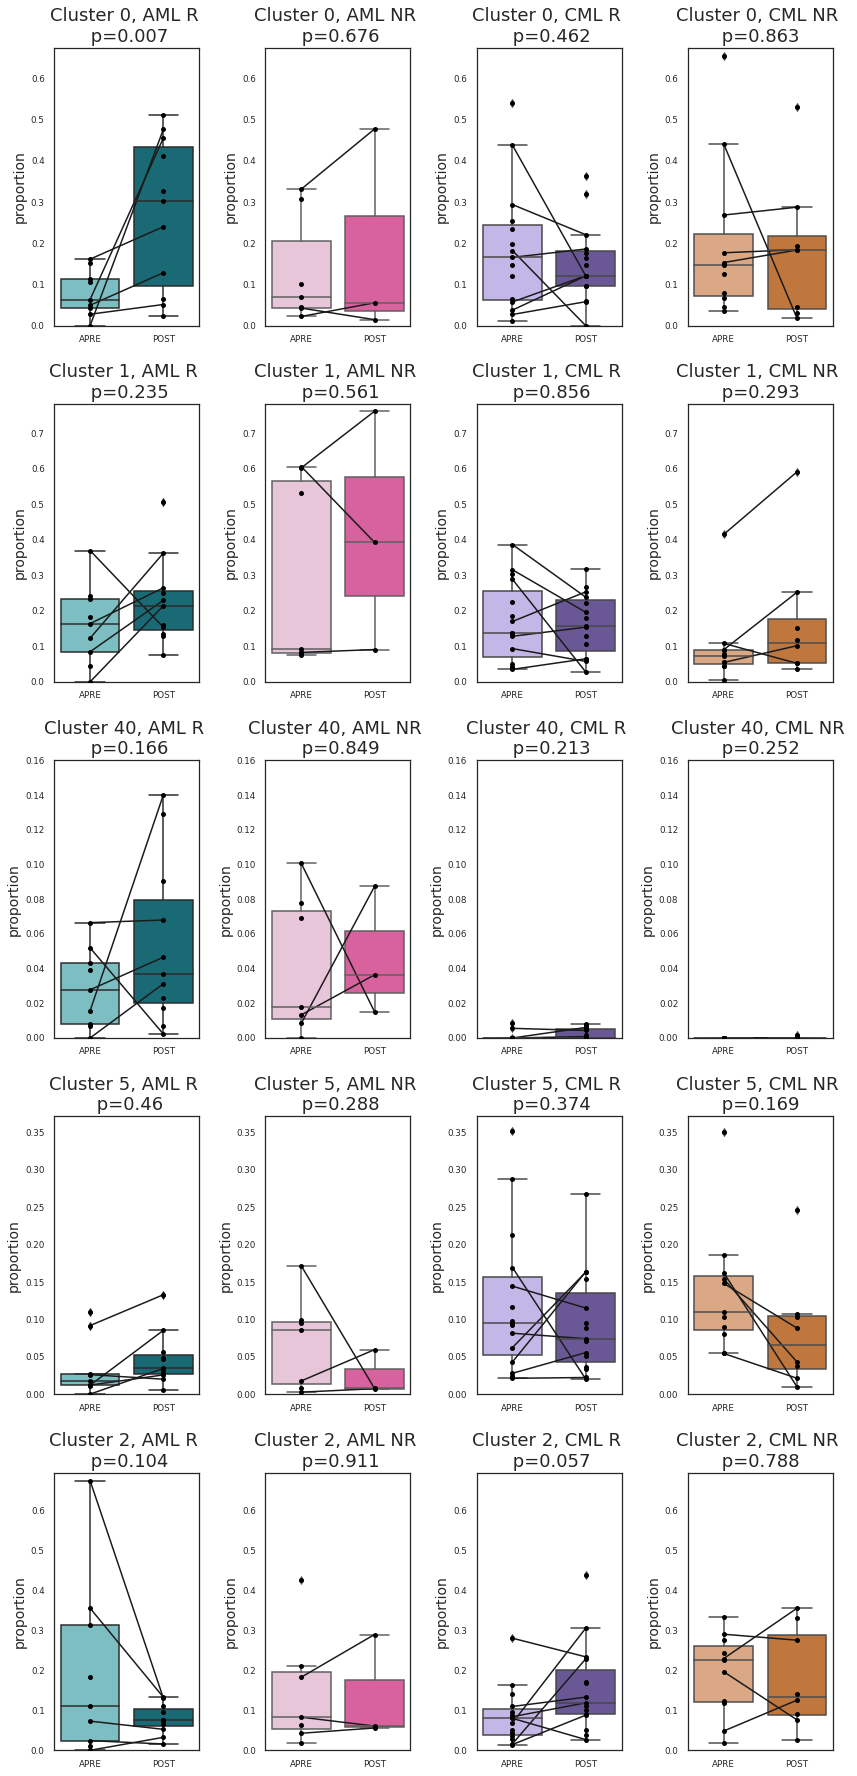

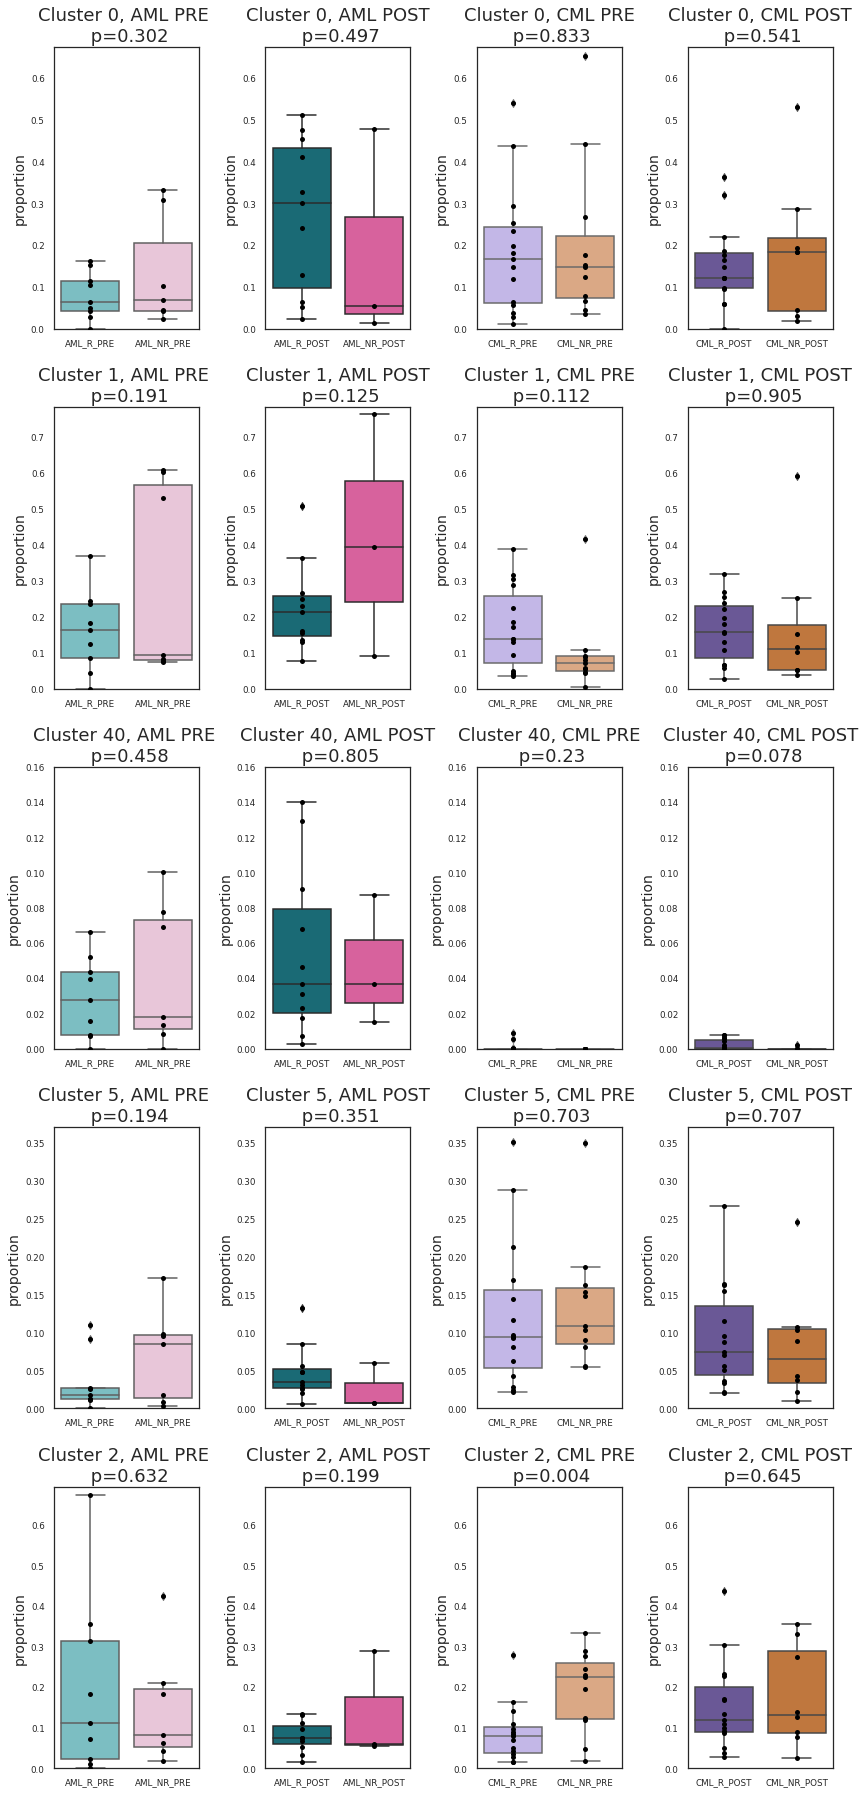

In [10]:

cml = umap_[umap_['DATA']=='CML']
cml_r = cml[cml['response']=='RESPONDER']
cml_nr = cml[cml['response']=='NONRESPONDER']
cml_r_pre = cml_r[cml_r['time']=='PRE']
cml_r_post = cml_r[cml_r['time']=='POST']
cml_nr_pre = cml_nr[cml_nr['time']=='PRE']
cml_nr_post = cml_nr[cml_nr['time']=='POST']

print('CML: ')
total_r_pre = cml_r_pre.shape[0]
total_nr_pre = cml_nr_pre.shape[0]
print('R_pre: ',total_r_pre,'NR_pre: ',total_nr_pre)

total_r_post = cml_r_post.shape[0]
total_nr_post = cml_nr_post.shape[0]
print('R_post: ',total_r_post,'NR_post: ',total_nr_post)

aml = umap_[umap_['DATA']=='AML']
aml_r = aml[aml['response']=='RESPONDER']
aml_nr = aml[aml['response']=='NONRESPONDER']
aml_r_pre = aml_r[aml_r['time']=='PRE']
aml_r_post = aml_r[aml_r['time']=='POST']
aml_nr_pre = aml_nr[aml_nr['time']=='PRE']
aml_nr_post = aml_nr[aml_nr['time']=='POST']

print('AML: ')
total_r_pre = aml_r_pre.shape[0]
total_nr_pre = aml_nr_pre.shape[0]
print('R_pre: ',total_r_pre,'NR_pre: ',total_nr_pre)

total_r_post = aml_r_post.shape[0]
total_nr_post = aml_nr_post.shape[0]
print('R_post: ',total_r_post,'NR_post: ',total_nr_post)

### Count number of cells in each cluster that belong to each sample

cellcount_df = pd.DataFrame(index = np.unique(umap_['sample']), columns = np.unique(umap_['cluster_number'].astype(str)))
cellcount_df['total'] = np.zeros(len(cellcount_df))

for sample in np.unique(umap_['sample']):

    df = umap_[umap_['sample']==sample]
    cellcount_df.loc[sample,'total'] = len(df)
    
    for cluster in np.unique(umap_['cluster_number'].astype(str)):
        cluster_len = len(df[df['cluster_number']==int(cluster)])
        cellcount_df.loc[sample,cluster] = cluster_len 
    
ms = cellcount_df.sum(axis=0)
cellcount_df = cellcount_df.drop(columns = cellcount_df.loc[:,ms==0].columns)

#drop clusters that don't have cells in any AML BM samples
cellcount_df = cellcount_df[cellcount_df['total']>0]

# divide by total number of cells in that sample
cellratio_df = cellcount_df.div(cellcount_df['total'],axis = 0)

P_VALUE = 0.05
## R vs. NR

#get list of all samples for each response group
aml_r_pre_samples = np.unique(aml_r_pre['sample'])
aml_r_post_samples = np.unique(aml_r_post['sample'])
aml_nr_pre_samples = np.unique(aml_nr_pre['sample'])
aml_nr_post_samples = np.unique(aml_nr_post['sample'])


cml_r_pre_samples = np.unique(cml_r_pre['sample'])
cml_r_post_samples = np.unique(cml_r_post['sample'])
cml_nr_pre_samples = np.unique(cml_nr_pre['sample'])
cml_nr_post_samples = np.unique(cml_nr_post['sample'])


# calculate all ratios for each response group
aml_r_pre_ratios = cellratio_df.loc[aml_r_pre_samples,:]
aml_r_post_ratios = cellratio_df.loc[aml_r_post_samples,:]

# if needed to artifially include 0's when using the myeloid only cells
# aml_r_post_ratios.loc['LB_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['KC_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['EL_post'] = np.zeros(len(aml_r_post_ratios.columns))
# aml_r_post_ratios.loc['MS_post'] = np.zeros(len(aml_r_post_ratios.columns))


aml_nr_pre_ratios = cellratio_df.loc[aml_nr_pre_samples,:]
aml_nr_post_ratios = cellratio_df.loc[aml_nr_post_samples,:]

cml_r_pre_ratios = cellratio_df.loc[cml_r_pre_samples,:]
cml_r_post_ratios = cellratio_df.loc[cml_r_post_samples,:]
cml_nr_pre_ratios = cellratio_df.loc[cml_nr_pre_samples,:]
cml_nr_post_ratios = cellratio_df.loc[cml_nr_post_samples,:]


##### COMPARING R AND NR

sample_R = aml_r_pre_ratios
sample_NR = aml_nr_pre_ratios
p_value_pre_aml = []
print('AML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue   
    if i=='total': continue
        
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]
    p_value_pre_aml.append(p)
        
        
sample_R = cml_r_pre_ratios
sample_NR = cml_nr_pre_ratios
p_value_pre = []
print('CML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_pre.append(p)


sample_R = aml_r_post_ratios
sample_NR = aml_nr_post_ratios
p_value_post_aml = []
print('AML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
        
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   

    p_value_post_aml.append(p)
        
        
sample_R = cml_r_post_ratios
sample_NR = cml_nr_post_ratios
p_value_post = []
print('CML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_post.append(p)
    
    
    
### COMPARING PRE AND POST

sample_R = aml_r_pre_ratios
sample_NR = aml_r_post_ratios
p_value_r_aml = []
print('AML R')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue  
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_r_aml.append(p)

        
        
sample_R = cml_r_pre_ratios
sample_NR = cml_r_post_ratios
p_value_r = []
print('CML R')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_r.append(p)

    
    

sample_R = aml_nr_pre_ratios
sample_NR = aml_nr_post_ratios
p_value_nr_aml = []
print('AML NR')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue  
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_nr_aml.append(p)

        
        
sample_R = cml_nr_pre_ratios
sample_NR = cml_nr_post_ratios
p_value_nr = []
col_arr = []
print('CML NR')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue
    if i=='total': continue
    col_arr.append(i)
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]   
    p_value_nr.append(p)



p_df = pd.DataFrame()

p_df['CML_R'] = p_value_r
p_df['CML_NR'] = p_value_nr
p_df['CML_PRE'] = p_value_pre
p_df['CML_POST'] = p_value_post


p_df['AML_R'] = p_value_r_aml
p_df['AML_NR'] = p_value_nr_aml
p_df['AML_PRE'] = p_value_pre_aml
p_df['AML_POST'] = p_value_post_aml

p_df.index= col_arr


# combined everything 

cml_r_pre_ratios['time']= np.repeat('PRE',len(cml_r_pre_ratios))
cml_r_post_ratios['time']= np.repeat('POST',len(cml_r_post_ratios))
aml_r_pre_ratios['time']= np.repeat('PRE',len(aml_r_pre_ratios))
aml_r_post_ratios['time']= np.repeat('POST',len(aml_r_post_ratios))

cml_nr_pre_ratios['time']= np.repeat('PRE',len(cml_nr_pre_ratios))
cml_nr_post_ratios['time']= np.repeat('POST',len(cml_nr_post_ratios))
aml_nr_pre_ratios['time']= np.repeat('PRE',len(aml_nr_pre_ratios))
aml_nr_post_ratios['time']= np.repeat('POST',len(aml_nr_post_ratios))

cml_r_pre_ratios['response']= np.repeat('R',len(cml_r_pre_ratios))
cml_nr_pre_ratios['response']= np.repeat('NR',len(cml_nr_pre_ratios))
aml_r_pre_ratios['response']= np.repeat('R',len(aml_r_pre_ratios))
aml_nr_pre_ratios['response']= np.repeat('NR',len(aml_nr_pre_ratios))

cml_r_post_ratios['response']= np.repeat('R',len(cml_r_post_ratios))
cml_nr_post_ratios['response']= np.repeat('NR',len(cml_nr_post_ratios))
aml_r_post_ratios['response']= np.repeat('R',len(aml_r_post_ratios))
aml_nr_post_ratios['response']= np.repeat('NR',len(aml_nr_post_ratios))

sample_ratios_aml_PRE = pd.concat([aml_r_pre_ratios,aml_nr_pre_ratios])
sample_ratios_cml_PRE = pd.concat([cml_r_pre_ratios,cml_nr_pre_ratios])
sample_ratios_aml_PRE = sample_ratios_aml_PRE.drop(columns = 'total')
sample_ratios_cml_PRE = sample_ratios_cml_PRE.drop(columns = 'total')

sample_ratios_aml_R = pd.concat([aml_r_pre_ratios,aml_r_post_ratios])
sample_ratios_cml_R = pd.concat([cml_r_pre_ratios,cml_r_post_ratios])
sample_ratios_aml_R = sample_ratios_aml_R.drop(columns = 'total')
sample_ratios_cml_R = sample_ratios_cml_R.drop(columns = 'total')

sample_ratios_aml_NR = pd.concat([aml_nr_pre_ratios,aml_nr_post_ratios])
sample_ratios_cml_NR = pd.concat([cml_nr_pre_ratios,cml_nr_post_ratios])
sample_ratios_aml_NR = sample_ratios_aml_NR.drop(columns = 'total')
sample_ratios_cml_NR = sample_ratios_cml_NR.drop(columns = 'total')

sample_cml = pd.concat([sample_ratios_cml_R,sample_ratios_cml_NR])
sample_aml = pd.concat([sample_ratios_aml_R,sample_ratios_aml_NR])
sample_cml['data'] = np.repeat('CML',len(sample_cml))
sample_aml['data'] = np.repeat('AML',len(sample_aml))

all_sample_ratios = pd.concat([sample_cml,sample_aml])

arr = []
for sample in all_sample_ratios.index:
    data = all_sample_ratios.loc[sample,'data']
    response = all_sample_ratios.loc[sample,'response']
    string = data+ '_'+response
    arr.append(string)

    
all_sample_ratios['data_response'] = arr

arr = []
arr1 = []
for sample in all_sample_ratios.index:
    data = all_sample_ratios.loc[sample,'data']
    time = all_sample_ratios.loc[sample,'time']
    response = all_sample_ratios.loc[sample,'response']
    string = data+ '_'+time
    arr.append(string)
    
    string1 = data+'_'+response+'_'+time
    arr1.append(string1)

    
all_sample_ratios['data_time'] = arr
all_sample_ratios['response_group'] = arr1
## add patient column:
patient_arr = []
for sample in all_sample_ratios.index:
#     print(sample)
    if sample == 'LB_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'MS_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'KC_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    if sample == 'EL_post':
        patient = 'LB'
        patient_arr.append(patient)
        continue
    df_ = umap_[umap_['sample'] == sample]
    patient = np.unique(df_['patient'])[0]
    patient_arr.append(patient)
all_sample_ratios['patient'] = patient_arr



new_time_arr = []
for index in all_sample_ratios.index: 
    time = all_sample_ratios.loc[index, 'time']
    if time == 'PRE':
        new_time_arr.append('APRE')
    else: new_time_arr.append('POST')
all_sample_ratios['time'] = new_time_arr


aml_r_pre_color = '#70C8CE'
aml_r_post_color = '#0B7684'

aml_nr_pre_color = '#EEC0DA'
aml_nr_post_color = '#EA4E9D'

cml_r_pre_color = '#BFAFEF'
cml_r_post_color = '#664EA0'

cml_nr_pre_color = '#E8A577'
cml_nr_post_color = '#D57528'

sample_connect = ['B5_','B6_','B1_','B2_','B9_','B10_','B21_','B22_','B25_','B3_', 'B4_'
                  'B32_','B32_','B24_','B27_','B28_','B7_','B8_','B17_','B18_','B19_','B20_',
                  'E1_','E2_','E3_','E4_',
                 'MS4_', 'MS3_', 'LB3_','LB1_', 'EL1_', 'EL2_' , 'KC2_', 'KC4_', 'BB11_', 'BB2_', 
                 'GD1_', 'GD2_', 'AH1_', 'AH3_', 'JS1_', 'JS2_','LB_post','MS_post','KC_post' ,'EL_post',
                 'AML1_1','AML2']



p_df = p_df.dropna(axis = 1, how = 'all')






############## EXPANSIONS ############################

### BOX PLOTS OF ALL EXPANSIONS

p_df_expansion = p_df[['CML_R','CML_NR','AML_R','AML_NR']]
# p_df_expansion = p_df[['AML_R','AML_NR']]
cluster_arr = []
for cluster in p_df_expansion.index: 
    p = np.min(p_df_expansion.loc[cluster])
    if p>0.08: continue
    else: cluster_arr.append(cluster)

cluster_arr = ['0','1','40','5','2']
# cluster_arr = ['0']
        
n = len(cluster_arr)*4; max_cols = 4
nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
fig = plt.figure(figsize = [3*ncols, 5*nrows])
j = 0

for cluster in cluster_arr:
    
    aml = all_sample_ratios[all_sample_ratios['data']=='AML']
    aml_r = aml[aml['response']=='R']
    aml_nr = aml[aml['response']=='NR']

    cml = all_sample_ratios[all_sample_ratios['data']=='CML']
    cml_r = cml[cml['response']=='R']
    cml_nr = cml[cml['response']=='NR']
    # one figure for each expansion group (i.e. AML R pre->post is one group)

    


    aml_r_max = np.max(aml_r[cluster])
    aml_nr_max = np.max(aml_nr[cluster])
    cml_r_max = np.max(cml_r[cluster])
    cml_nr_max = np.max(cml_nr[cluster])
    a = [aml_r_max,aml_nr_max,cml_r_max,cml_nr_max]
    cleanedList = [x for x in a if str(x) != 'nan']
    max_y = np.max(cleanedList) + 0.02

    p_vals = p_df.loc[cluster]


    DF = aml_r
    color_set = [aml_r_pre_color, aml_r_post_color]
    p = np.round(p_vals['AML_R'],3)
    axes = fig.add_subplot(nrows, ncols, j+1)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    if cluster == '0': print(line_df)
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
#     print(f'CLUSTER {cluster}')
#     print(line_df)
    axes.set_title(f'Cluster {cluster}, AML R \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')

    DF = aml_nr
    color_set = [aml_nr_pre_color, aml_nr_post_color]
    p = np.round(p_vals['AML_NR'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+2)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    if cluster == '0': print(line_df)
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)

    axes.set_title(f'Cluster {cluster}, AML NR \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_r
    color_set = [cml_r_pre_color, cml_r_post_color]
    p = np.round(p_vals['CML_R'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+3)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
    #     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    axes.set_title(f'Cluster {cluster}, CML R \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_nr
    color_set = [cml_nr_pre_color, cml_nr_post_color]
    p = np.round(p_vals['CML_NR'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+4)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='time',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='time', y=cluster,color = 'black', jitter = False)
    line_df = DF[['patient','time',cluster]].sort_values(by = 'time', ascending = False)
    keep = []
    for sample in sample_connect:
        if sample not in line_df.index:
            continue
        keep.append(sample)
    line_df = line_df.loc[keep]
    box = sns.lineplot(data = line_df,x='time', y=cluster, units= 'patient',color='.1', estimator=None)
    #     plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
    axes.set_title(f'Cluster {cluster}, CML NR \n p={p} ', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
    
    j += 4

fig.tight_layout(pad = 2) 
plt.show()


############## ENRICHMENTS ###################


# ### BOX PLOTS OF ALL EXPANSIONS
p_df_expansion = p_df[['CML_PRE','CML_POST','AML_PRE','AML_POST']]
# p_df_expansion = p_df[['AML_R','AML_NR']]
cluster_arr = []
for cluster in p_df_expansion.index: 
    p = np.min(p_df_expansion.loc[cluster])
    if p>0.08: continue
    else: cluster_arr.append(cluster)
        
# cluster_arr = tcells

# cluster_arr = np.unique(umap_['cluster_number'])



n = len(cluster_arr)*4; max_cols = 4
nrows = int(np.ceil(n / max_cols)); ncols = int(min((max_cols, n)))
fig = plt.figure(figsize = [3*ncols, 5*nrows])
j = 0
cluster_arr =  ['0','1','40','5','2']

for cluster in cluster_arr:
#     print(cluster)
#     if len(cluster_arr)==0: break
    
    aml = all_sample_ratios[all_sample_ratios['data']=='AML']
    aml_pre = aml[aml['time']=='APRE']
    aml_post = aml[aml['time']=='POST']

    cml = all_sample_ratios[all_sample_ratios['data']=='CML']
    cml_pre = cml[cml['time']=='APRE']
    cml_post = cml[cml['time']=='POST']
    
    # one figure for each expansion group (i.e. AML R pre->post is one group)
    aml_r_max = np.max(aml_pre[cluster])
    aml_nr_max = np.max(aml_post[cluster])
    cml_r_max = np.max(cml_pre[cluster])
    cml_nr_max = np.max(cml_post[cluster])

    a = [aml_r_max,aml_nr_max,cml_r_max,cml_nr_max]
    cleanedList = [x for x in a if str(x) != 'nan']
    max_y = np.max(cleanedList) + 0.02

    p_vals = p_df.loc[cluster]
    

    DF = aml_pre
    color_set = [aml_r_pre_color, aml_nr_pre_color]
    p = np.round(p_vals['AML_PRE'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+1)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, AML PRE \n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
                   

    DF = aml_post
    color_set = [aml_r_post_color, aml_nr_post_color]
    p = np.round(p_vals['AML_POST'],3)
                   
                   
    axes = fig.add_subplot(nrows, ncols, j+2)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, AML POST\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_pre
    color_set = [cml_r_pre_color, cml_nr_pre_color]
    p = np.round(p_vals['CML_PRE'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+3)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, CML PRE\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')


    DF = cml_post
    color_set = [cml_r_post_color, cml_nr_post_color]
    p = np.round(p_vals['CML_POST'],3)
    
    axes = fig.add_subplot(nrows, ncols, j+4)
    axes.set_ylim(0,max_y)
    sns.set(font_scale = 0.8, style = 'white')
    df = DF[['patient','time','response_group',cluster]].sort_values(by = 'time')
    box = sns.boxplot(data=df,x='response_group',   y=cluster,palette = color_set)
    box = sns.stripplot(data=df, x='response_group', y=cluster,color = 'black', jitter = False)
    axes.set_title(f'Cluster {cluster}, CML POST\n p={p}', fontsize = 18)
    axes.set_ylabel('proportion', fontsize = 14)
    axes.set_xlabel('')
    
    j += 4

fig.tight_layout(pad = 2) 
plt.show()







# BOXPLOTS FOR CONTROLS and DLI PRODUCT

AML: 
R_pre:  16097 NR_pre:  7724
R_post:  25931 NR_post:  1619
ctrl: 
pre:  16964 post:  10167 non relapse:  7617
product: 
R:  25206 NR:  18712
AML


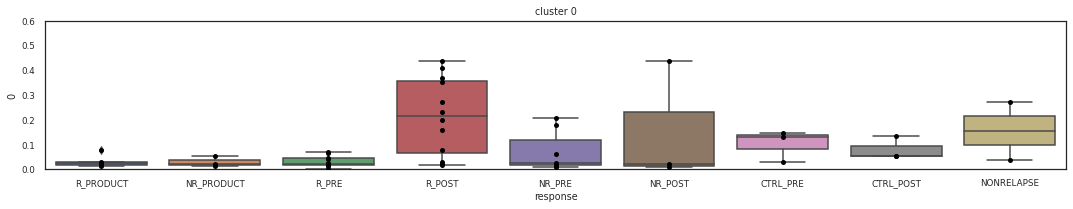

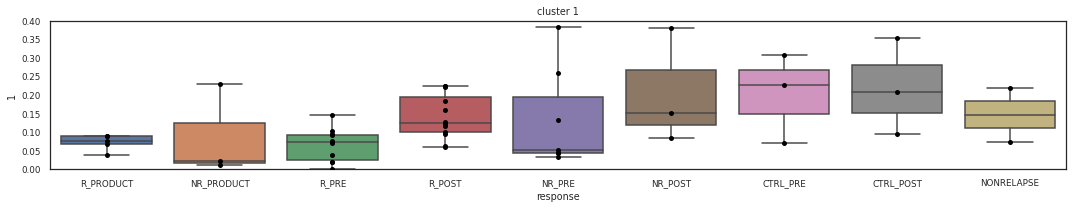

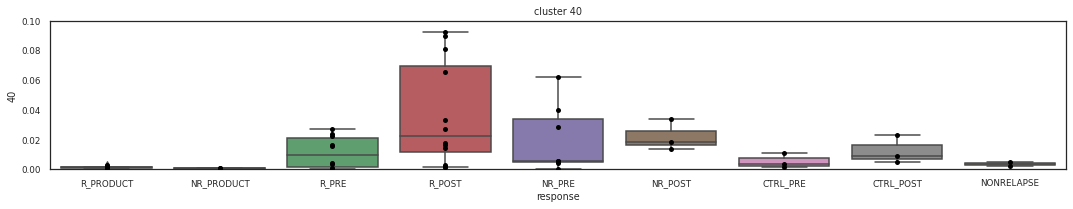

In [14]:
### Create dataframes that split all data into response groups
umap_ = pd.read_csv('~/mainmap_umap_0811.csv', index_col = 0)

# aml = umap_[umap_['dataset']=='dli']
r_product = ['EE_', 'EL_',  'KC_', 'LB_', 'MS_']
nr_product =['JS_', 'p24_', 'p25_']

ctrl_pre_samp = ['ctrl1', 'ctrl3',  'ctrl5']
ctrl_post_samp =['ctrl2', 'ctrl4',  'ctrl6',]
non_relapse_samp = ['ctrl7','ctrl8']


aml = umap_[umap_['DATA']=='AML']
aml_r = aml[aml['response']=='RESPONDER']
aml_nr = aml[aml['response']=='NONRESPONDER']
aml_r_pre = aml_r[aml_r['time']=='PRE']
aml_r_post = aml_r[aml_r['time']=='POST']
aml_nr_pre = aml_nr[aml_nr['time']=='PRE']
aml_nr_post = aml_nr[aml_nr['time']=='POST']

print('AML: ')
total_r_pre = aml_r_pre.shape[0]
total_nr_pre = aml_nr_pre.shape[0]
print('R_pre: ',total_r_pre,'NR_pre: ',total_nr_pre)

total_r_post = aml_r_post.shape[0]
total_nr_post = aml_nr_post.shape[0]
print('R_post: ',total_r_post,'NR_post: ',total_nr_post)

# for rr in r_product:
#     print(rr)
#     df = aml[aml['sample']==rr]
#     aml.loc[df.index, 'response'] = 'dli_R'
    
# for rr in nr_product:
#     print(rr)
#     df = aml[aml['sample']==rr]
#     aml.loc[df.index, 'response'] = 'dli_NR'
    
    
aml_r_product = umap_[umap_['sample'].isin(r_product)]
aml_nr_product= umap_[umap_['sample'].isin(nr_product)]

ctrl_pre = umap_[umap_['sample'].isin(ctrl_pre_samp)]
ctrl_post = umap_[umap_['sample'].isin(ctrl_post_samp)]
non_relapse = umap_[umap_['sample'].isin(non_relapse_samp)]

print('ctrl: ')
print('pre: ',len(ctrl_pre),'post: ',len(ctrl_post),'non relapse: ',len(non_relapse))



print('product: ')
print('R: ',len(aml_r_product),'NR: ', len(aml_nr_product))



all_samples = list(ctrl_pre_samp+ctrl_post_samp+non_relapse_samp+
               list(np.unique(aml_r_pre['sample']))+list(np.unique(aml_nr_pre['sample']))+
               list(np.unique(aml_r_post['sample']))+list(np.unique(aml_nr_post['sample']))
                  + list(np.unique(aml_r_product['sample']))+list(np.unique(aml_nr_product['sample'])))

umap_ = umap_[umap_['sample'].isin(all_samples)]


### Count number of cells in each cluster that belong to each sample

cellcount_df = pd.DataFrame(index = np.unique(umap_['sample']), columns = np.unique(umap_['cluster_number']))
cellcount_df['total'] = np.zeros(len(cellcount_df))

for sample in np.unique(umap_['sample']):

    df = umap_[umap_['sample']==sample]
    cellcount_df.loc[sample,'total'] = len(df)
    
    for cluster in np.unique(umap_['cluster_number']):
        cluster_len = len(df[df['cluster_number']==int(cluster)])
        cellcount_df.loc[sample,cluster] = cluster_len 
    
ms = cellcount_df.sum(axis=0)
cellcount_df = cellcount_df.drop(columns = cellcount_df.loc[:,ms==0].columns)

#drop clusters that don't have cells in any AML BM samples
cellcount_df = cellcount_df[cellcount_df['total']>0]

# divide by total number of cells in that sample
cellratio_df = cellcount_df.div(cellcount_df['total'],axis = 0)
cellratio_df = cellratio_df.drop(columns = 'total')
# cellratio_df = cellratio_df[[ 0,  1,  2,  3,  4,  5,  7, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21,
#        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41,
#        42, 43, 44, 45, 48, 49, 50, 52, 53, 57]]
P_VALUE = 0.05
## R vs. NR

#get list of all samples for each response group
# aml_r_samples = np.unique(aml_r['sample'])
# aml_nr_samples = np.unique(aml_nr['sample'])

# calculate all ratios for each response group
aml_r_pre_ratios = cellratio_df.loc[list(np.unique(aml_r_pre['sample'])),:]
aml_nr_pre_ratios = cellratio_df.loc[list(np.unique(aml_nr_pre['sample'])),:]
aml_r_post_ratios = cellratio_df.loc[list(np.unique(aml_r_post['sample'])),:]
aml_nr_post_ratios = cellratio_df.loc[list(np.unique(aml_nr_post['sample'])),:]

aml_r_product_ratios = cellratio_df.loc[r_product,:]
aml_nr_product_ratios = cellratio_df.loc[nr_product,:]

ctrl_pre_ratios = cellratio_df.loc[ctrl_pre_samp,:]
ctrl_post_ratios = cellratio_df.loc[ctrl_post_samp,:]
ctrl_nonrelapse_ratios = cellratio_df.loc[non_relapse_samp,:]

##### COMPARING R AND NR

sample_R = ctrl_pre_ratios
sample_NR = ctrl_post_ratios
p_value_aml = []
print('AML')
for i in cellratio_df.columns:
    if i not in sample_R.columns: continue
    if i not in sample_NR.columns: continue   
    if i=='total': continue
        
    R_arr = sample_R.loc[:,i].astype(float)
    NR_arr = sample_NR.loc[:,i].astype(float)
    p = ttest_ind(R_arr,NR_arr, alternative = 'two-sided')[1]
    p_value_aml.append(p)
  

p_df = pd.DataFrame(index = cellratio_df.columns, columns = ['ctrl'])

p_df['ctrl'] = p_value_aml

aml_r_pre_ratios['response'] = 'R_PRE'
aml_r_post_ratios['response'] = 'R_POST'
aml_nr_pre_ratios['response'] = 'NR_PRE'
aml_nr_post_ratios['response'] = 'NR_POST'

aml_r_product_ratios['response'] = 'R_PRODUCT'
aml_nr_product_ratios['response'] = 'NR_PRODUCT'

ctrl_pre_ratios['response'] = 'CTRL_PRE'
ctrl_post_ratios['response'] = 'CTRL_POST'
ctrl_nonrelapse_ratios['response'] = 'NONRELAPSE'

ratios = pd.concat([
    aml_r_product_ratios, aml_nr_product_ratios,
                   aml_r_pre_ratios, aml_r_post_ratios,
                   aml_nr_pre_ratios, aml_nr_post_ratios,
                   ctrl_pre_ratios, ctrl_post_ratios, ctrl_nonrelapse_ratios])



cluster_arr = [0,1,40] #2,3,5,10,18,25,
# cluster_arr = [0]
y_arr = [0.6,0.4,0.1]
# cluster_arr = [1]
for i,cluster in enumerate(cluster_arr):
    y_lim = y_arr[i]
#     cluster = str(cluster)
    plt.figure(figsize = (15,3))
    plt.ylim([0,y_lim])
    sns.boxplot(x = ratios['response'], y = ratios[cluster])
    sns.stripplot(data=ratios, x='response', y=cluster,color = 'black', jitter = False)
    p = np.round(list(p_df.loc[int(cluster)])[0],3)
    plt.title(f'cluster {cluster}')
    plt.tight_layout()
#     plt.savefig(f'ctrl_boxplot_{cluster}.eps')
    plt.show()